# Controlled Model Performance Analysis

This notebook analyzes the performance of the AI detector tested in a controlled offline environment, providing valid results that were not affected by the deployment issue.

## Data Sources
- Overall model metrics: `controlled model results/art_subset_metrics.json`
- Performance by generator: `controlled model results/art_subset_generator_metrics.json`
- Performance by art style: `controlled model results/art_subset_style_metrics.json`

## 1. Import Libraries and Load Data

In [23]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set up plot styling
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette('viridis')

In [24]:
# Load controlled model results
base_path = "controlled model results/"

# Load overall metrics
with open(f"{base_path}art_subset_metrics.json", 'r') as f:
    overall_metrics = json.load(f)

# Load generator-specific metrics
with open(f"{base_path}art_subset_generator_metrics.json", 'r') as f:
    generator_metrics = json.load(f)

# Load style-specific metrics
with open(f"{base_path}art_subset_style_metrics.json", 'r') as f:
    style_metrics = json.load(f)

print("Data loaded successfully!")
print(f"Overall model accuracy: {overall_metrics['accuracy']:.1%}")
print(f"Number of generators analyzed: {len(generator_metrics)}")
print(f"Number of art styles analyzed: {len(style_metrics)}")

Data loaded successfully!
Overall model accuracy: 88.6%
Number of generators analyzed: 7
Number of art styles analyzed: 21


## 2. Overall Model Performance

In [25]:
# Display overall metrics
print("=== CONTROLLED MODEL PERFORMANCE ===")
print(f"Accuracy:    {overall_metrics['accuracy']:.1%}")
print(f"Precision:   {overall_metrics['precision']:.1%}")
print(f"Recall:      {overall_metrics['recall']:.1%}")
print(f"F1-Score:    {overall_metrics['f1']:.1%}")
print(f"AUC:         {overall_metrics['auc']:.3f}")
print(f"AP:          {overall_metrics['ap']:.3f}")
print(f"Specificity: {overall_metrics['specificity']:.1%}")
print(f"Sensitivity: {overall_metrics['sensitivity']:.1%}")

# Confusion matrix
cm = np.array(overall_metrics['confusion_matrix'])
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                Human    AI")
print(f"Actual Human   {cm[0,0]:6d}  {cm[0,1]:4d}")
print(f"       AI      {cm[1,0]:6d}  {cm[1,1]:4d}")

=== CONTROLLED MODEL PERFORMANCE ===
Accuracy:    88.6%
Precision:   88.4%
Recall:      88.8%
F1-Score:    88.6%
AUC:         0.964
AP:          0.971
Specificity: 88.4%
Sensitivity: 88.8%

Confusion Matrix:
                 Predicted
                Human    AI
Actual Human      442    58
       AI          56   444


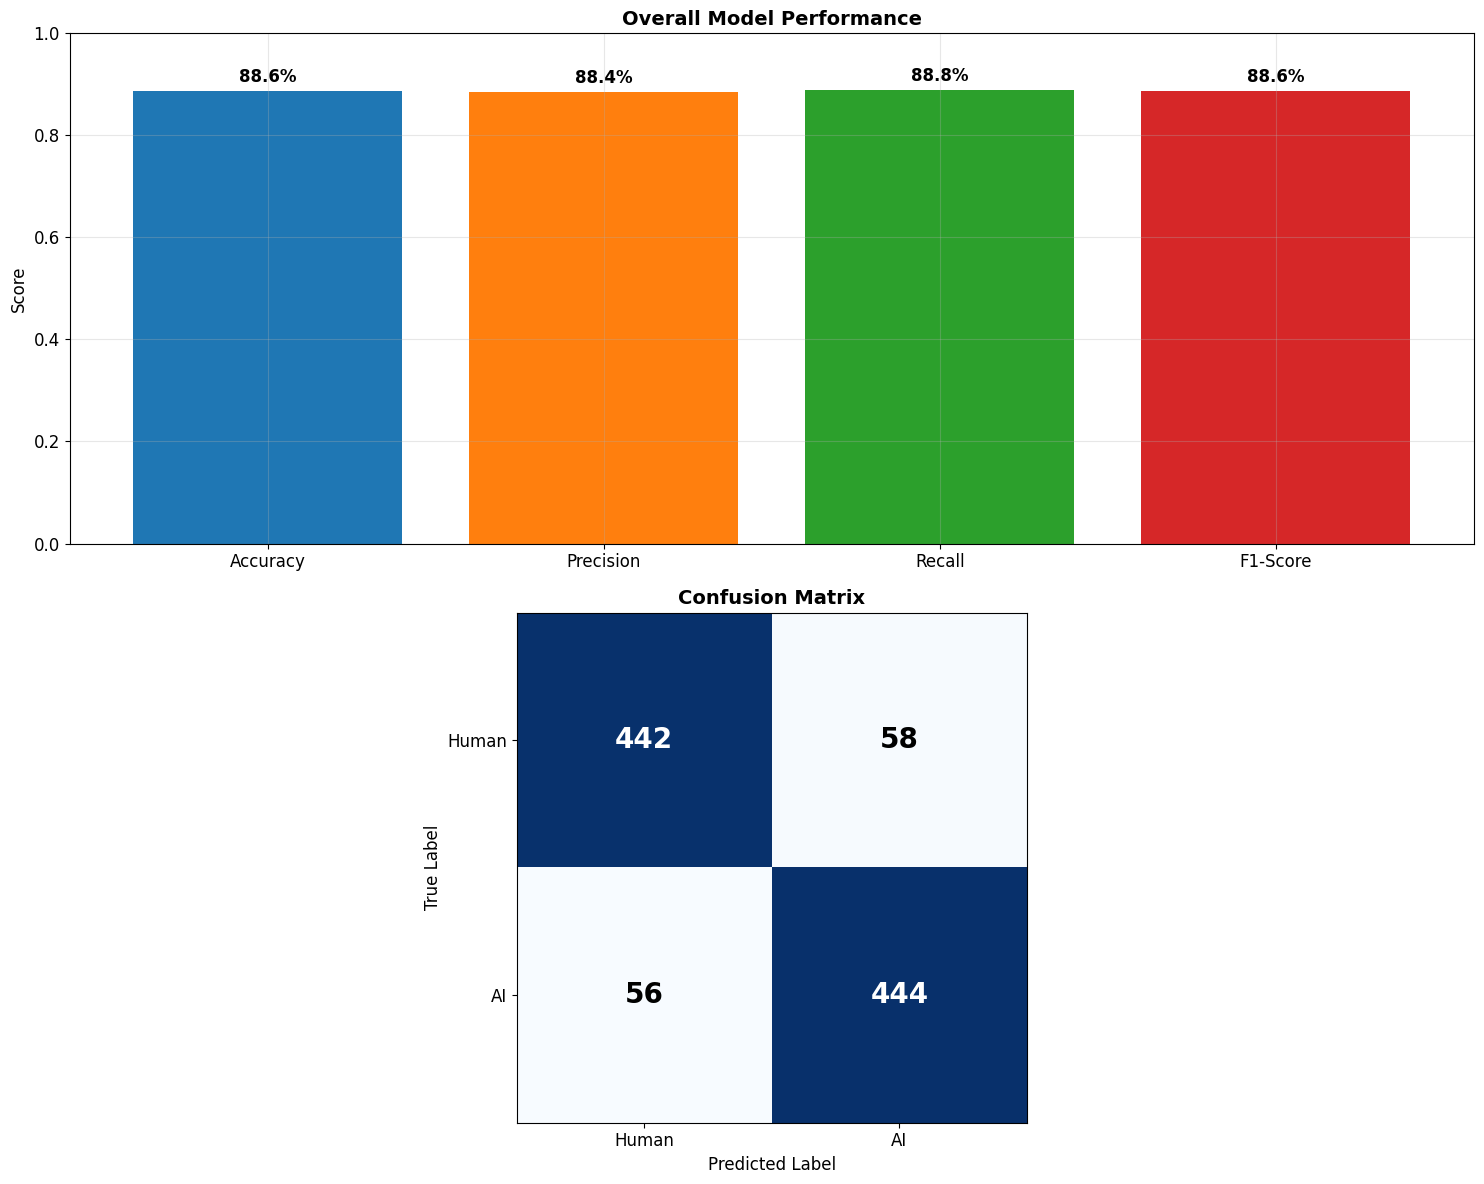

In [33]:
# Visualize overall performance metrics
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# 1. Overall metrics bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [overall_metrics['accuracy'], overall_metrics['precision'], 
          overall_metrics['recall'], overall_metrics['f1']]

bars = ax1.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax1.set_title('Overall Model Performance', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.1%}', ha='center', va='bottom', fontweight='bold')

# 2. Confusion Matrix
cm_labels = ['Human', 'AI']
im = ax2.imshow(cm, interpolation='nearest', cmap='Blues')
ax2.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
tick_marks = np.arange(len(cm_labels))
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_xticklabels(cm_labels)
ax2.set_yticklabels(cm_labels)
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# Add text annotations
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        ax2.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=20, fontweight='bold')



plt.tight_layout()
plt.show()

## 3. Performance by Generator (including human-made art)

In [27]:
# Convert generator metrics to DataFrame for easier analysis
gen_df = pd.DataFrame(generator_metrics).T
gen_df = gen_df.sort_values('accuracy', ascending=True)  # Sort by accuracy (hardest to easiest)

print("=== PERFORMANCE BY GENERATOR (Hardest to Easiest to Detect) ===")
for generator, row in gen_df.iterrows():
    print(f"{generator:20s}: {row['accuracy']:.1%} accuracy, {row['f1']:.1%} F1, ({row['count']} images)")

print(f"\nHardest to detect: {gen_df.index[0]} ({gen_df.iloc[0]['accuracy']:.1%})")
print(f"Easiest to detect: {gen_df.index[-1]} ({gen_df.iloc[-1]['accuracy']:.1%})")

=== PERFORMANCE BY GENERATOR (Hardest to Easiest to Detect) ===
dreamstudio         : 77.1% accuracy, 87.1% F1, (83.0 images)
starryai            : 78.6% accuracy, 88.0% F1, (84.0 images)
dalle               : 86.7% accuracy, 92.9% F1, (83.0 images)
human               : 88.4% accuracy, 0.0% F1, (500.0 images)
midjourney          : 91.7% accuracy, 95.7% F1, (84.0 images)
original_ldm        : 98.8% accuracy, 99.4% F1, (83.0 images)
stable_diffusion    : 100.0% accuracy, 100.0% F1, (83.0 images)

Hardest to detect: dreamstudio (77.1%)
Easiest to detect: stable_diffusion (100.0%)


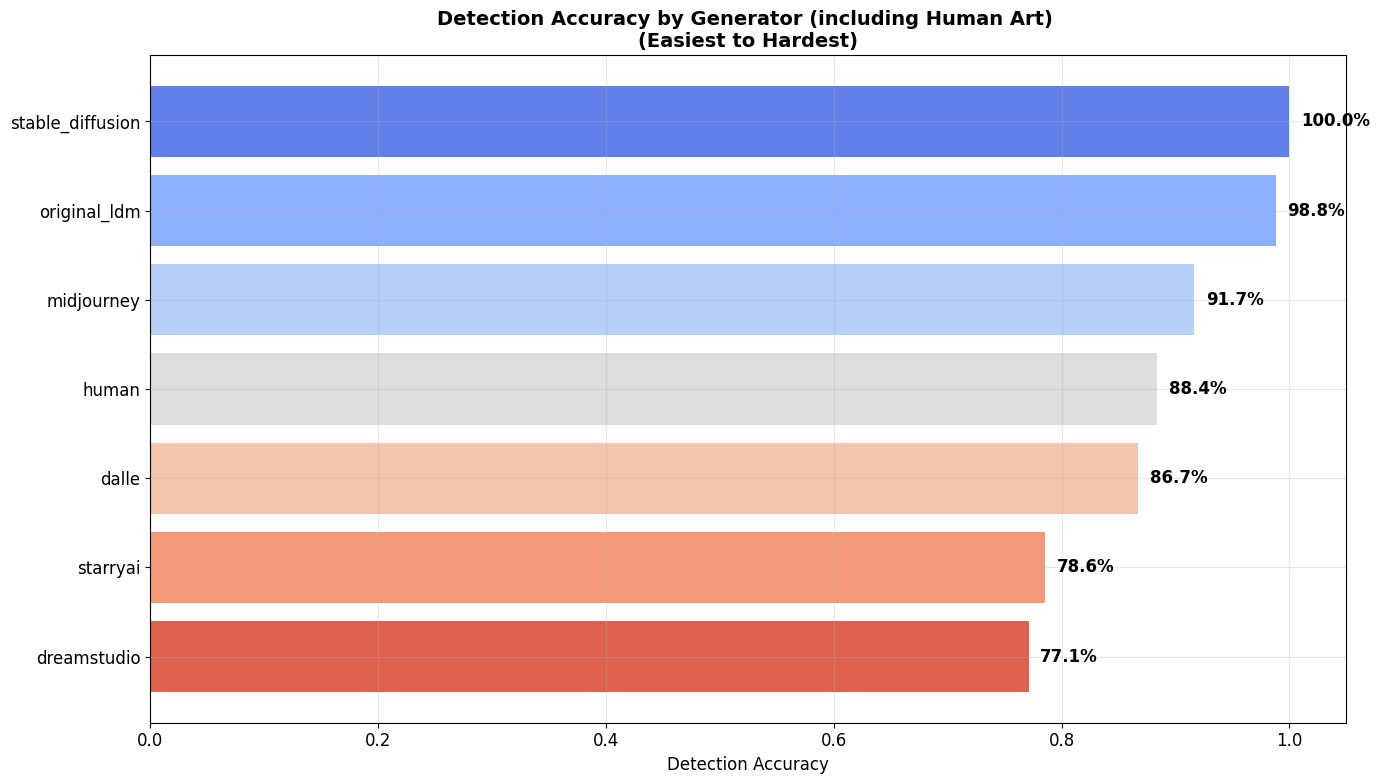

In [29]:
# Visualize detection accuracy by generator
fig, ax = plt.subplots(1, 1, figsize=(14, 8))


# Accuracy by Generator
#colors = plt.cm.viridis(np.linspace(0, 1, len(gen_df)))
colors = sns.color_palette(palette='coolwarm_r', n_colors=len(gen_df))
    
bars = ax.barh(range(len(gen_df)), gen_df['accuracy'], color=colors)
ax.set_yticks(range(len(gen_df)))
ax.set_yticklabels(gen_df.index)
ax.set_xlabel('Detection Accuracy')
ax.set_title('Detection Accuracy by Generator (including Human Art) \n(Easiest to Hardest)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add value labels
for i, (bar, accuracy) in enumerate(zip(bars, gen_df['accuracy'])):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{accuracy:.1%}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

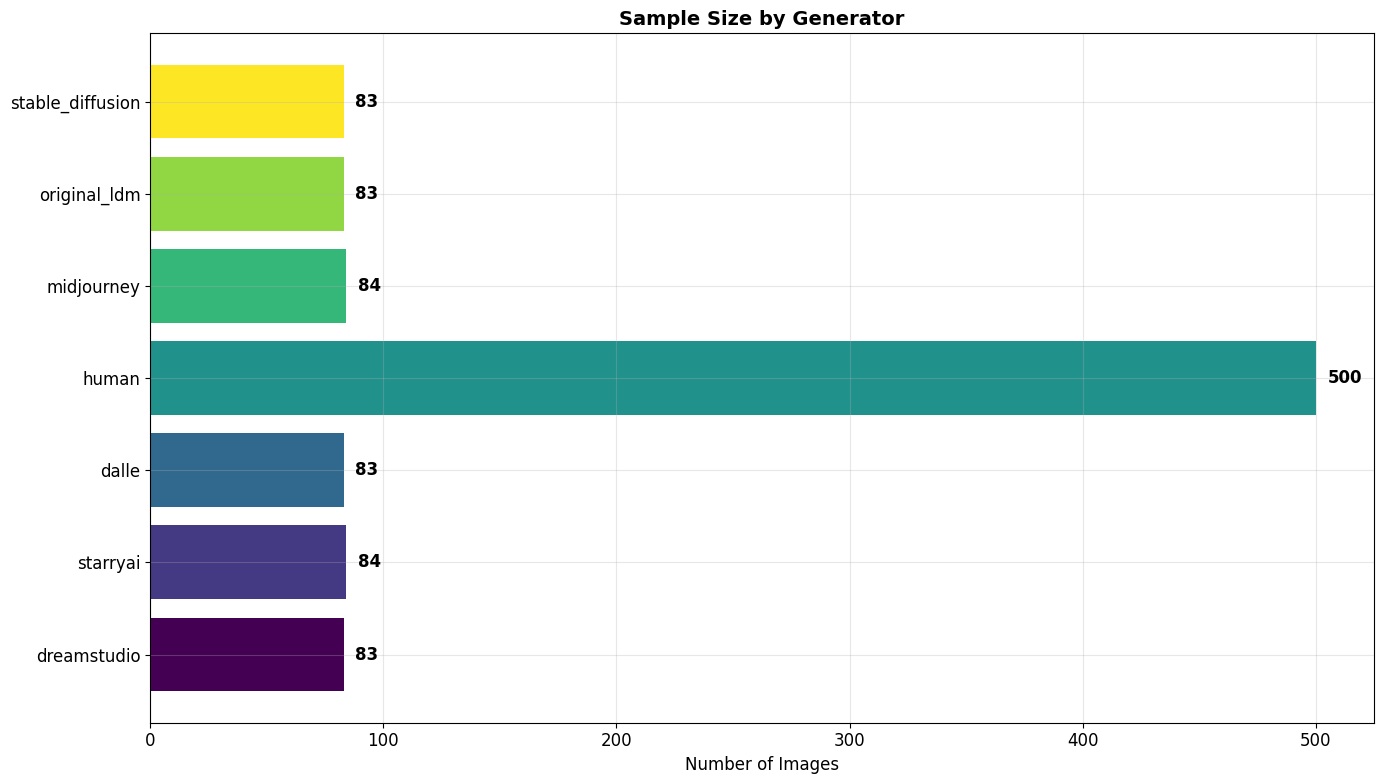

In [29]:
# Visualize sample size by generator
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Sample Count by Generator
colors = plt.cm.viridis(np.linspace(0, 1, len(gen_df)))
bars = ax.barh(range(len(gen_df)), gen_df['count'], color=colors)
ax.set_yticks(range(len(gen_df)))
ax.set_yticklabels(gen_df.index)
ax.set_xlabel('Number of Images')
ax.set_title('Sample Size by Generator', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add value labels
for i, (bar, count) in enumerate(zip(bars, gen_df['count'])):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
             f'{int(count)}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Performance by Art Style

In [35]:
print(f"Number of art styles tested: {len(style_df)}")

Number of art styles tested: 21


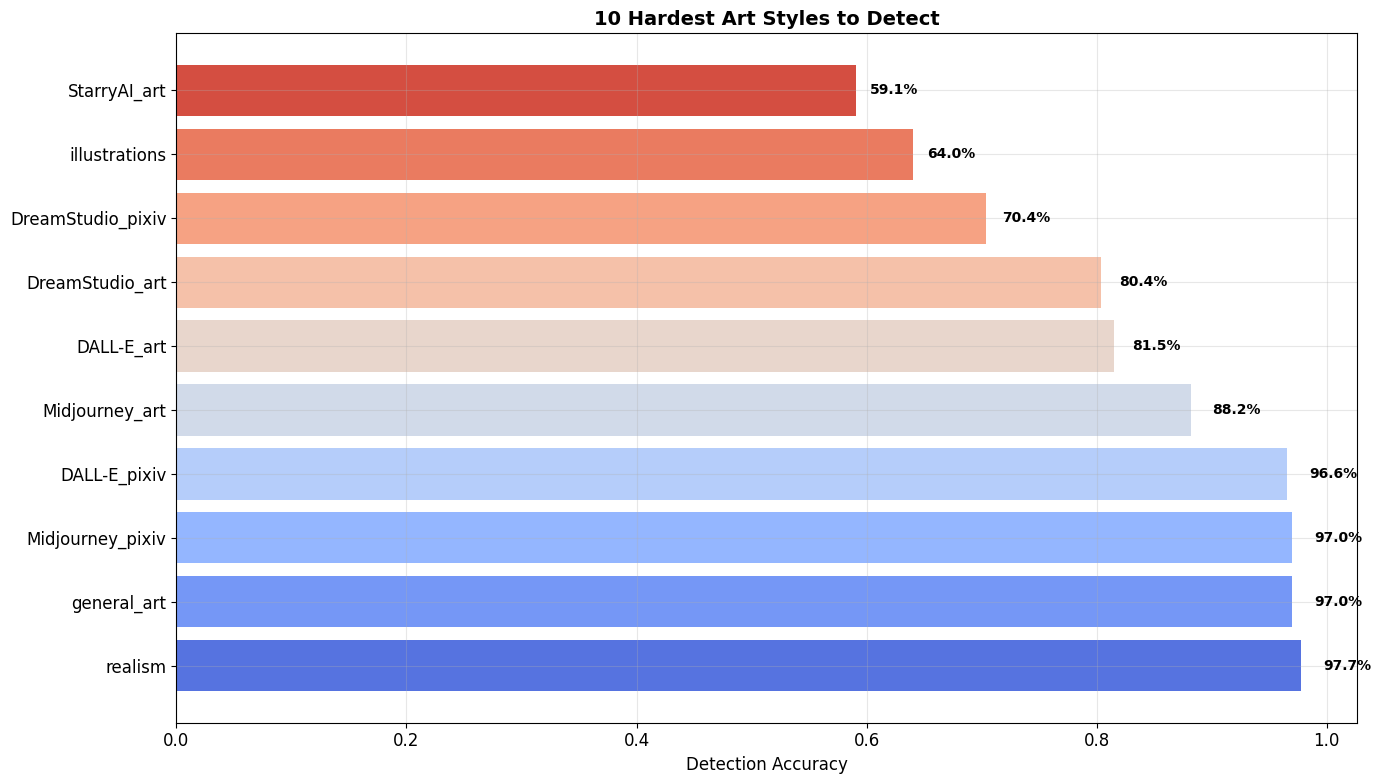

In [22]:
# Visualize top 10 hardest art styles to detect
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Top 10 hardest styles
hardest_10 = style_df.head(10)[::-1]
colors_hard = sns.color_palette('coolwarm', len(hardest_10))
bars = ax.barh(range(len(hardest_10)), hardest_10['accuracy'], color=colors_hard)
ax.set_yticks(range(len(hardest_10)))
ax.set_yticklabels(hardest_10.index)
ax.set_xlabel('Detection Accuracy')
ax.set_title('10 Hardest Art Styles to Detect', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add value labels
for i, (bar, accuracy) in enumerate(zip(bars, hardest_10['accuracy'])):
    ax.text(bar.get_width() * 1.02, bar.get_y() + bar.get_height()/2,
             f'{accuracy:.1%}', va='center', ha='left', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

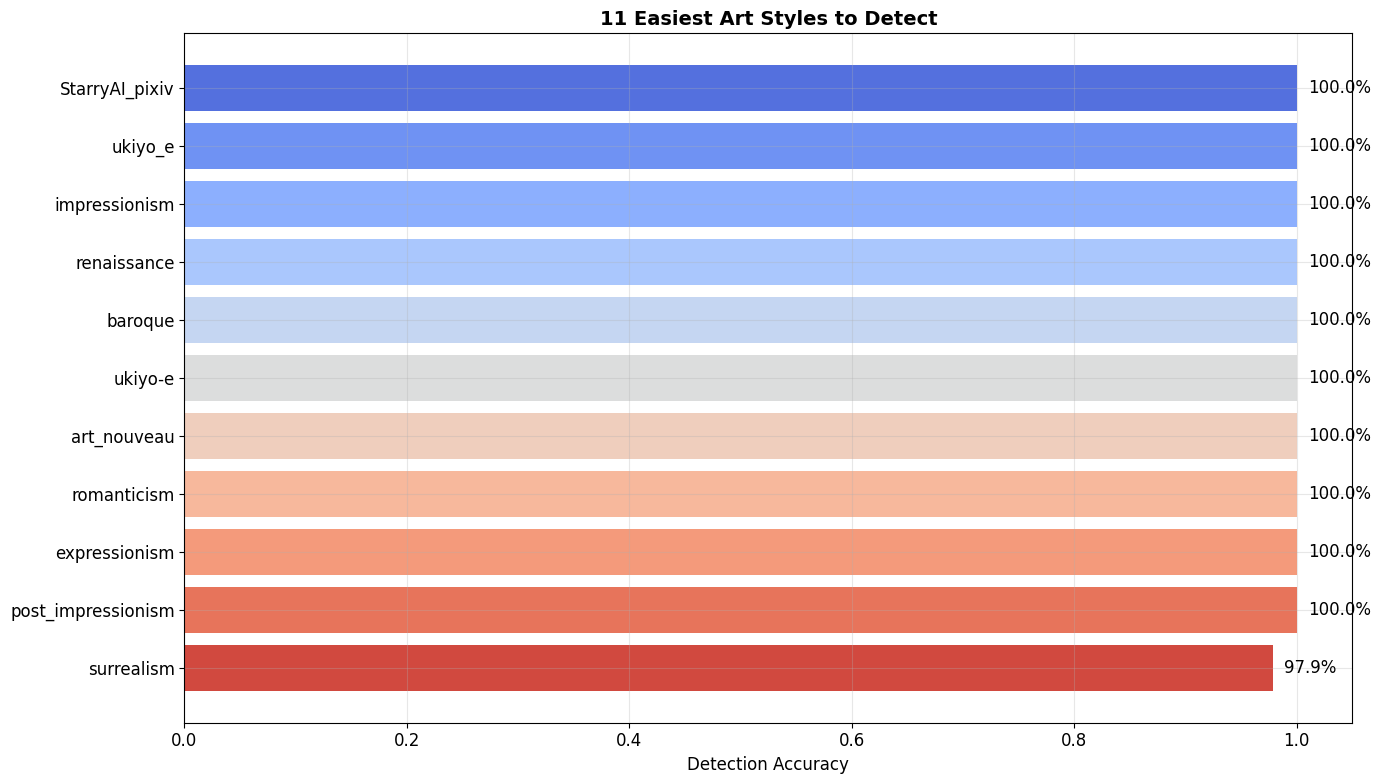

In [26]:
# Visualize top 10 easiest art styles to detect
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Top 10 easiest styles
easiest_10 = style_df.tail(11)
colors_easy = sns.color_palette('coolwarm_r', len(easiest_10))
#colors_easy = plt.cm.Greens(np.linspace(0.3, 1, len(easiest_10)))
bars = ax.barh(range(len(easiest_10)), easiest_10['accuracy'], color=colors_easy)
ax.set_yticks(range(len(easiest_10)))
ax.set_yticklabels(easiest_10.index)
ax.set_xlabel('Detection Accuracy')
ax.set_title('11 Easiest Art Styles to Detect', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add value labels
for i, (bar, accuracy) in enumerate(zip(bars, easiest_10['accuracy'])):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{accuracy:.1%}', va='center')

plt.tight_layout()
plt.show()